# 07_Implementacion_Modelo

!pip install openpyxl

In [25]:
# Instalar paquetes necesarios (ejecutar solo una vez)
!pip install pandas numpy matplotlib statsmodels pmdarima prophet scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
!pip install seaborn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
!pip install pmdarima --upgrade


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:

# Importar biblitecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
# Leer el archivo CSV
file_path = '../Data/Input/df_completo.xlsx'  
df_completo = pd.read_excel(file_path)


In [34]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30073 entries, 0 to 30072
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              30073 non-null  datetime64[ns]
 1   Producto           30073 non-null  object        
 2   Precio_Sogamoso    30073 non-null  float64       
 3   Precio_Tunja       30073 non-null  float64       
 4   Precio_Duitama     30073 non-null  float64       
 5   Precio_Bogotá      30073 non-null  float64       
 6   Promedio_Mercados  30073 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.6+ MB


## Prophet

In [35]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

productos = df_completo['Producto'].unique()

# Listas para guardar resultados
resultados = []
graficas = []

# Recorrer productos
for producto in productos:
    try:
        # Filtrar datos del producto
        df_producto = df_completo[df_completo['Producto'] == producto].copy()
        df_producto = df_producto.rename(columns={'Fecha': 'ds', 'Precio_Sogamoso': 'y'})

        columnas = ['ds', 'y', 'Promedio_Mercados']
        if not all(col in df_producto.columns for col in columnas):
            continue

        df_producto = df_producto[columnas].dropna()
        if len(df_producto) < 30:
            continue

        df_producto = df_producto.sort_values('ds').reset_index(drop=True)

        # División 80/20 sin importar fechas
        split_index = int(len(df_producto) * 0.8)
        train = df_producto.iloc[:split_index]
        test = df_producto.iloc[split_index:]

        if len(train) < 20 or len(test) == 0:
            continue

        # Crear modelo Prophet
        model = Prophet(
            changepoint_prior_scale=0.5,
            n_changepoints=40,
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False
        )

        model.add_regressor('Promedio_Mercados')
        model.fit(train)

        future = test[['ds', 'Promedio_Mercados']]
        forecast = model.predict(future)

        # Evaluación
        y_true = test['y'].values
        y_pred = forecast['yhat'].values
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        resultados.append({
            'Producto': producto,
            'MAE': round(mae, 2),
            'MSE': round(mse, 2),
            'RMSE': round(rmse, 2),
            'R2': round(r2, 4),
            'N_datos_train': len(train),
            'N_datos_test': len(test)
        })

        graficas.append({
            'producto': producto,
            'ds': test['ds'],
            'real': test['y'],
            'pred': forecast['yhat'],
            'lower': forecast['yhat_lower'],
            'upper': forecast['yhat_upper']
        })

    except Exception as e:
        print(f"Error con producto {producto}: {e}")

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).sort_values(by='RMSE')
print(df_resultados)


11:40:11 - cmdstanpy - INFO - Chain [1] start processing
11:40:12 - cmdstanpy - INFO - Chain [1] done processing
11:40:12 - cmdstanpy - INFO - Chain [1] start processing
11:40:13 - cmdstanpy - INFO - Chain [1] done processing
11:40:13 - cmdstanpy - INFO - Chain [1] start processing
11:40:14 - cmdstanpy - INFO - Chain [1] done processing
11:40:14 - cmdstanpy - INFO - Chain [1] start processing
11:40:14 - cmdstanpy - INFO - Chain [1] done processing
11:40:15 - cmdstanpy - INFO - Chain [1] start processing
11:40:17 - cmdstanpy - INFO - Chain [1] done processing
11:40:17 - cmdstanpy - INFO - Chain [1] start processing
11:40:18 - cmdstanpy - INFO - Chain [1] done processing
11:40:18 - cmdstanpy - INFO - Chain [1] start processing
11:40:18 - cmdstanpy - INFO - Chain [1] done processing
11:40:19 - cmdstanpy - INFO - Chain [1] start processing
11:40:19 - cmdstanpy - INFO - Chain [1] done processing
11:40:19 - cmdstanpy - INFO - Chain [1] start processing
11:40:19 - cmdstanpy - INFO - Chain [1]

                   Producto      MAE          MSE     RMSE       R2  \
26            Naranja Comun     0.32         0.13     0.36   1.0000   
29           Papaya Maradol    95.76     15142.17   123.05   0.9224   
4              Banano Urabá    97.54     26463.58   162.68   0.5427   
39                Zanahoria   138.66     42409.94   205.94   0.8072   
5   Cebolla Cabezona Blanca   142.32     51919.46   227.86   0.9341   
34                Remolacha   189.20     60843.83   246.67   0.9259   
17             Mango Azucar   229.42     61047.07   247.08   0.5695   
36            Tomate Chonto   208.69     66319.13   257.53   0.9301   
15                     Lulo   215.88     67591.18   259.98   0.8471   
16                Mandarina   213.59     71775.56   267.91   0.9586   
24                    Melon   211.73     71864.57   268.08   0.7391   
14             Limon Tahití   216.22     82858.93   287.85   0.9529   
28      Papa Criolla Limpia   192.32     84235.23   290.23   0.9142   
38    

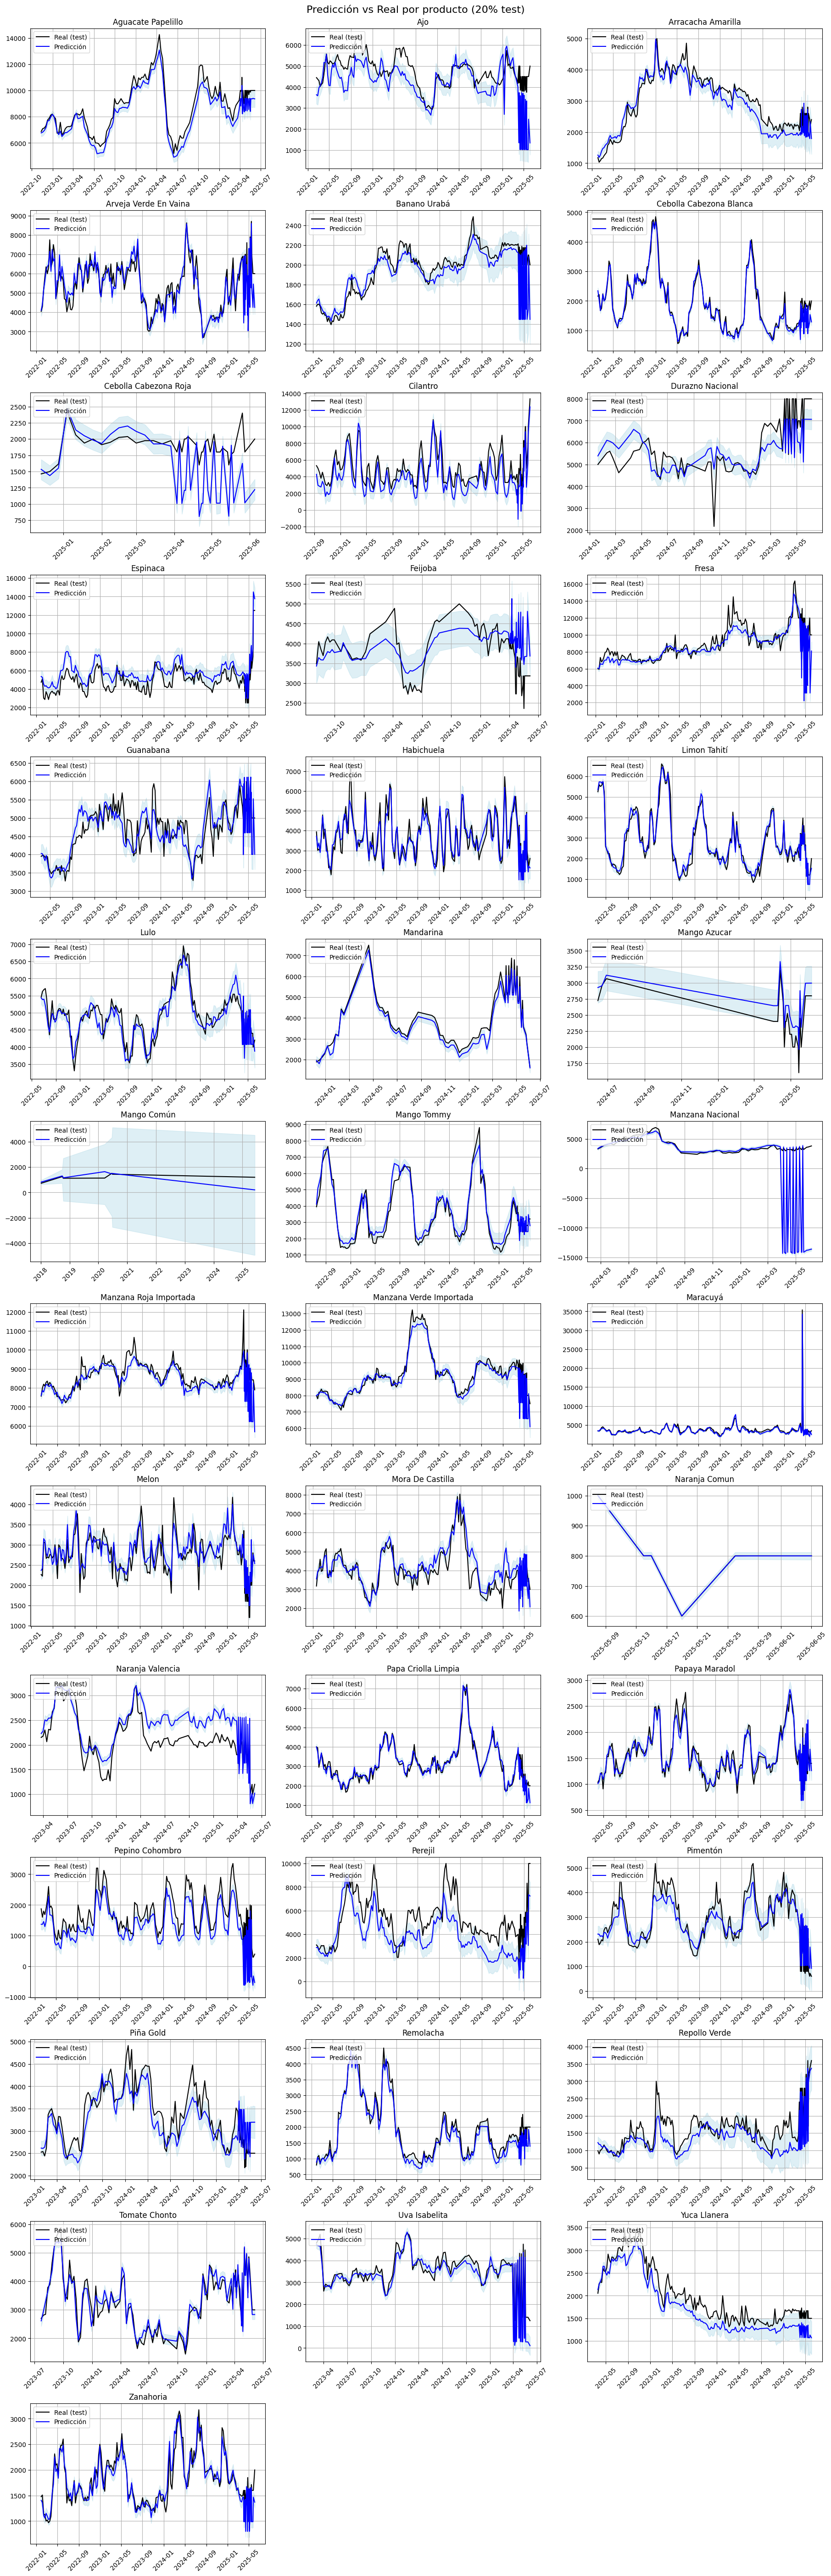

In [36]:
# ----------- GRAFICAR PREDICCIONES (solo test) -----------
n = len(graficas)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), constrained_layout=True)
axes = axes.flatten()

for i, graf in enumerate(graficas):
    ax = axes[i]

    # Graficar solo el 20% de test
    ax.plot(graf['ds'], graf['real'], label='Real (test)', color='black')
    ax.plot(graf['ds'], graf['pred'], label='Predicción', color='blue')
    ax.fill_between(graf['ds'], graf['lower'], graf['upper'], color='lightblue', alpha=0.4)

    ax.set_title(graf['producto'])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    ax.legend(loc='upper left')

# Eliminar ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Predicción vs Real por producto (20% test)', fontsize=16)
plt.show()


### Con todos los mercados

In [37]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30073 entries, 0 to 30072
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              30073 non-null  datetime64[ns]
 1   Producto           30073 non-null  object        
 2   Precio_Sogamoso    30073 non-null  float64       
 3   Precio_Tunja       30073 non-null  float64       
 4   Precio_Duitama     30073 non-null  float64       
 5   Precio_Bogotá      30073 non-null  float64       
 6   Promedio_Mercados  30073 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.6+ MB


In [38]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

productos = df_completo['Producto'].unique()

resultados = []
graficas = []

for producto in productos:
    try:
        # Filtrar y preparar datos
        df_producto = df_completo[df_completo['Producto'] == producto].copy()
        df_producto = df_producto.rename(columns={'Fecha': 'ds', 'Precio_Sogamoso': 'y'})

        columnas = ['ds', 'y', 'Precio_Duitama', 'Precio_Tunja', 'Precio_Bogotá', 'Promedio_Mercados']
        if not all(col in df_producto.columns for col in columnas):
            continue

        df_producto = df_producto[columnas].dropna()
        if len(df_producto) < 30:
            continue

        df_producto = df_producto.sort_values('ds').reset_index(drop=True)

        # División 80/20
        split_index = int(len(df_producto) * 0.8)
        train = df_producto.iloc[:split_index]
        test = df_producto.iloc[split_index:]

        if len(train) < 20 or len(test) == 0:
            continue

        # Modelo Prophet
        model = Prophet(
            changepoint_prior_scale=0.5,
            n_changepoints=40,
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False
        )

        # Agregar regresores
        model.add_regressor('Precio_Duitama')
        model.add_regressor('Precio_Tunja')
        model.add_regressor('Precio_Bogotá')
        model.add_regressor('Promedio_Mercados')

        # Entrenamiento
        model.fit(train)

        # Preparar futuro (debe incluir todos los regresores)
        future = test[['ds', 'Precio_Duitama', 'Precio_Tunja', 'Precio_Bogotá', 'Promedio_Mercados']]
        forecast = model.predict(future)

        # Evaluación
        y_true = test['y'].values
        y_pred = forecast['yhat'].values
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        resultados.append({
            'Producto': producto,
            'MAE': round(mae, 2),
            'MSE': round(mse, 2),
            'RMSE': round(rmse, 2),
            'R2': round(r2, 4),
            'N_datos_train': len(train),
            'N_datos_test': len(test)
        })

        graficas.append({
            'producto': producto,
            'ds': test['ds'],
            'real': test['y'],
            'pred': forecast['yhat'],
            'lower': forecast['yhat_lower'],
            'upper': forecast['yhat_upper']
        })

    except Exception as e:
        print(f"Error con producto {producto}: {e}")

# Resultados ordenados por RMSE
df_resultados = pd.DataFrame(resultados).sort_values(by='RMSE')
print(df_resultados)


11:42:36 - cmdstanpy - INFO - Chain [1] start processing
11:42:39 - cmdstanpy - INFO - Chain [1] done processing
11:42:39 - cmdstanpy - INFO - Chain [1] start processing
11:42:42 - cmdstanpy - INFO - Chain [1] done processing
11:42:42 - cmdstanpy - INFO - Chain [1] start processing
11:42:45 - cmdstanpy - INFO - Chain [1] done processing
11:42:46 - cmdstanpy - INFO - Chain [1] start processing
11:42:48 - cmdstanpy - INFO - Chain [1] done processing
11:42:49 - cmdstanpy - INFO - Chain [1] start processing
11:42:51 - cmdstanpy - INFO - Chain [1] done processing
11:42:52 - cmdstanpy - INFO - Chain [1] start processing
11:42:55 - cmdstanpy - INFO - Chain [1] done processing
11:42:55 - cmdstanpy - INFO - Chain [1] start processing
11:42:56 - cmdstanpy - INFO - Chain [1] done processing
11:42:56 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1]

                   Producto      MAE           MSE      RMSE         R2  \
26            Naranja Comun     0.02  0.000000e+00      0.02     1.0000   
35            Repollo Verde     1.58  3.780000e+01      6.15     0.9999   
38             Yuca Llanera     4.42  2.778300e+02     16.67     0.9992   
37            Uva Isabelita     8.60  5.238300e+02     22.89     0.9994   
0        Aguacate Papelillo    19.08  3.973310e+03     63.03     0.9989   
29           Papaya Maradol    19.22  5.029450e+03     70.92     0.9742   
30          Pepino Cohombro    25.30  9.907820e+03     99.54     0.9793   
34                Remolacha    29.37  1.233904e+04    111.08     0.9850   
24                    Melon    30.81  1.328241e+04    115.25     0.9518   
4              Banano Urabá    31.39  1.424203e+04    119.34     0.7539   
36            Tomate Chonto    50.08  1.523948e+04    123.45     0.9839   
39                Zanahoria    33.58  1.738451e+04    131.85     0.9210   
31                  Perej

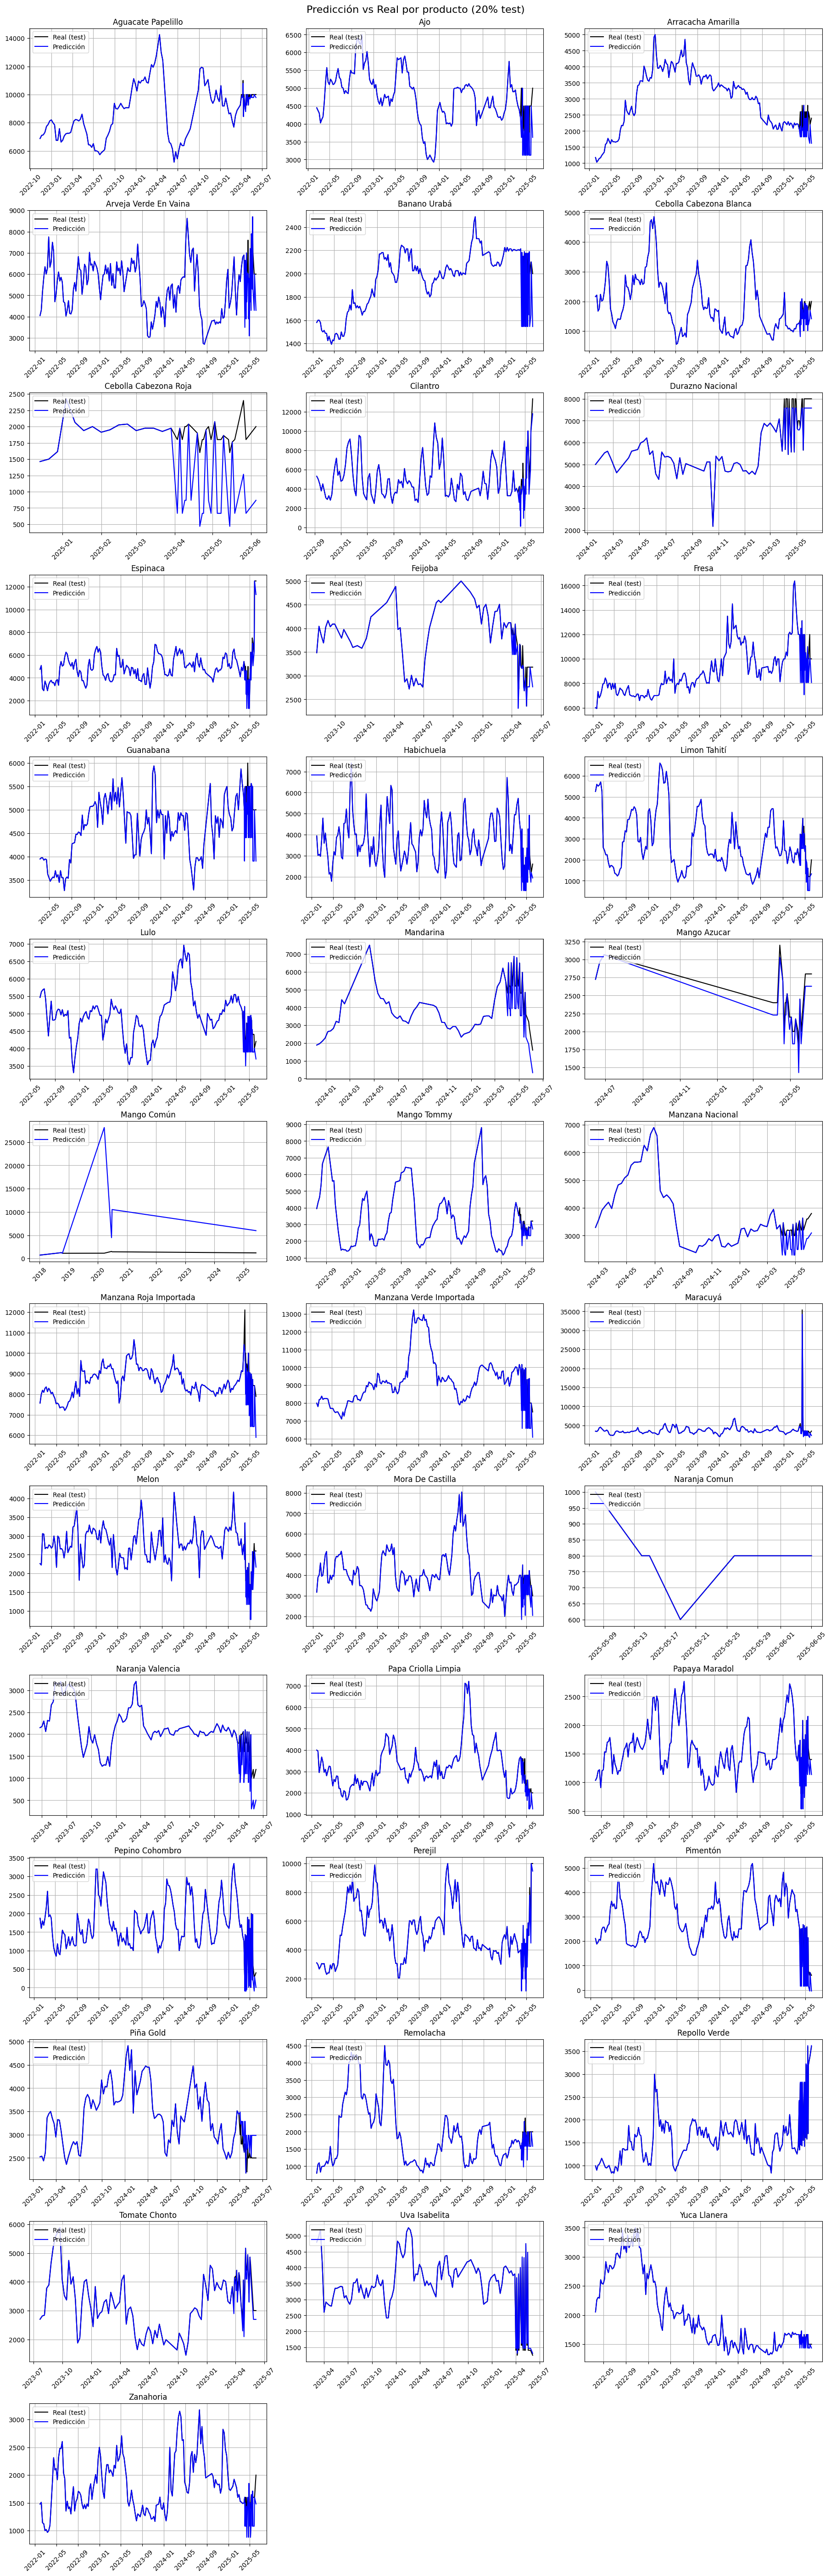

In [39]:
# ----------- GRAFICAR PREDICCIONES (solo test) -----------
n = len(graficas)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), constrained_layout=True)
axes = axes.flatten()

for i, graf in enumerate(graficas):
    ax = axes[i]

    # Graficar solo el 20% de test
    ax.plot(graf['ds'], graf['real'], label='Real (test)', color='black')
    ax.plot(graf['ds'], graf['pred'], label='Predicción', color='blue')
    ax.fill_between(graf['ds'], graf['lower'], graf['upper'], color='lightblue', alpha=0.4)

    ax.set_title(graf['producto'])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    ax.legend(loc='upper left')

# Eliminar ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Predicción vs Real por producto (20% test)', fontsize=16)
plt.show()


In [40]:
df_resultados.head(100)

Producto      MAE           MSE      RMSE         R2  \
26            Naranja Comun     0.02  0.000000e+00      0.02     1.0000   
35            Repollo Verde     1.58  3.780000e+01      6.15     0.9999   
38             Yuca Llanera     4.42  2.778300e+02     16.67     0.9992   
37            Uva Isabelita     8.60  5.238300e+02     22.89     0.9994   
0        Aguacate Papelillo    19.08  3.973310e+03     63.03     0.9989   
29           Papaya Maradol    19.22  5.029450e+03     70.92     0.9742   
30          Pepino Cohombro    25.30  9.907820e+03     99.54     0.9793   
34                Remolacha    29.37  1.233904e+04    111.08     0.9850   
24                    Melon    30.81  1.328241e+04    115.25     0.9518   
4              Banano Urabá    31.39  1.424203e+04    119.34     0.7539   
36            Tomate Chonto    50.08  1.523948e+04    123.45     0.9839   
39                Zanahoria    33.58  1.738451e+04    131.85     0.9210   
31                  Perejil    34.10  1.791385e+04    133.84     0.9950   
19              Mango Tommy    40.63  1.917780e+04    138.48     0.9916   
15                     Lulo    39.34  1.979730e+04    140.70     0.9552   
17             Mango Azucar   120.45  2.061714e+04    143.59     0.8546   
5   Cebolla Cabezona Blanca    40.91  2.384786e+04    154.43     0.9697   
10                  Feijoba    65.33  2.707665e+04    164.55     0.9263   
32                 Pimentón    44.53  2.850927e+04    168.85     0.9766   
13               Habichuela    46.18  3.060047e+04    174.93     0.9748   
14             Limon Tahití    48.35  3.227252e+04    179.65     0.9816   
33                Piña Gold    68.98  3.349446e+04    183.01     0.9196   
28      Papa Criolla Limpia    52.49  3.930409e+04    198.25     0.9600   
2        Arracacha Amarilla    55.01  4.263626e+04    206.49     0.9428   
8          Durazno Nacional   102.95  4.339504e+04    208.31     0.9740   
25         Mora De Castilla    66.20  6.296639e+04    250.93     0.9384   
27         Naranja Valencia   104.24  7.256117e+04    269.37     0.6611   
12                Guanabana    78.71  8.604453e+04    293.33     0.7922   
23                 Maracuyá    82.39  9.682254e+04    311.16     0.9836   
9                  Espinaca    83.36  9.930421e+04    315.13     0.9424   
20         Manzana Nacional   167.20  1.172870e+05    342.47     0.8947   
1                       Ajo    98.12  1.352145e+05    367.72     0.7158   
22  Manzana Verde Importada    99.47  1.406483e+05    375.03     0.9161   
7                  Cilantro   131.10  2.018785e+05    449.31     0.9526   
3     Arveja Verde En Vaina   119.40  2.024695e+05    449.97     0.8521   
11                    Fresa   135.33  2.615825e+05    511.45     0.9294   
21   Manzana Roja Importada   138.87  2.771224e+05    526.42     0.4510   
16                Mandarina   290.39  3.683290e+05    606.90     0.7877   
6     Cebolla Cabezona Roja   512.08  5.796464e+05    761.35   -15.5645   
18              Mango Común  5476.97  1.053599e+08  10264.50 -2143.4244   

    N_datos_train  N_datos_test  
26             28             7  
35            739           185  
38            714           179  
37            516           129  
0             577           145  
29            711           178  
30            742           186  
34            740           186  
24            728           182  
4             748           188  
36            436           110  
39            744           186  
31            740           186  
19            613           154  
15            664           167  
17            105            27  
5             743           186  
10            332            83  
32            744           187  
13            746           187  
14            716           180  
33            536           134  
28            747           187  
2             744           186  
8             312            78  
25            748           187  
27            505        

## XGBoost

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from datetime import timedelta

# Suponiendo que df_completo ya está cargado y contiene todos los productos
productos = df_completo['Producto'].unique()

# Listas para guardar resultados
resultados = []
graficas = []
mejores_parametros = {}

# Espacio de búsqueda para GridSearch
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Recorrer productos
for producto in productos:
    try:
        # Filtrar datos del producto
        df_producto = df_completo[df_completo['Producto'] == producto].copy()
        df_producto = df_producto.rename(columns={'Fecha': 'ds', 'Precio_Sogamoso': 'y'})

        columnas = ['ds', 'y', 'Promedio_Mercados']
        if not all(col in df_producto.columns for col in columnas):
            continue

        df_producto = df_producto[columnas].dropna()
        if len(df_producto) < 30:
            continue

        df_producto = df_producto.sort_values('ds')

        # Dividir entre train y test: últimos 2 meses
        ultima_fecha = df_producto['ds'].max()
        fecha_inicio_test = ultima_fecha - pd.DateOffset(months=2)

        test = df_producto[df_producto['ds'] >= fecha_inicio_test]
        train = df_producto[df_producto['ds'] < fecha_inicio_test]

        if len(train) < 20 or len(test) == 0:
            continue

        X_train = train[['Promedio_Mercados']]
        y_train = train['y']
        X_test = test[['Promedio_Mercados']]
        y_test = test['y']

        # Grid Search para encontrar mejores hiperparámetros
        grid_search = GridSearchCV(
            estimator=XGBRegressor(random_state=42, verbosity=0),
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=3,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Guardar mejores parámetros
        mejores_parametros[producto] = grid_search.best_params_

        # Predecir
        y_pred = best_model.predict(X_test)

        # Evaluar
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        resultados.append({
            'Producto': producto,
            'MAE': round(mae, 2),
            'MSE': round(mse, 2),
            'RMSE': round(rmse, 2),
            'R2': round(r2, 4),
            'N_datos_train': len(train),
            'N_datos_test': len(test)
        })

        graficas.append({
            'producto': producto,
            'ds': test['ds'],
            'real': y_test,
            'pred': y_pred
        })

    except Exception as e:
        print(f"Error con producto {producto}: {e}")

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).sort_values(by='R2')
print(df_resultados)




                   Producto      MAE          MSE     RMSE      R2  \
1                       Ajo  1018.51   1267385.70  1125.78 -8.4036   
32                Piña Gold   269.74     97193.51   311.76 -0.9842   
37             Yuca Llanera    91.79     10770.68   103.78 -0.5892   
10                  Feijoba   494.75    285190.99   534.03 -0.4232   
2        Arracacha Amarilla   269.99     77979.56   279.25 -0.2699   
20         Manzana Nacional   219.91     55032.08   234.59 -0.1113   
12                Guanabana   170.17     54519.57   233.49 -0.0608   
23                 Maracuyá  1281.98  34907487.31  5908.26  0.1063   
11                    Fresa   838.24    962765.80   981.21  0.1976   
0        Aguacate Papelillo   406.24    188427.43   434.08  0.2223   
15                     Lulo   207.99     61847.23   248.69  0.3426   
9                  Espinaca  1066.88   3804097.71  1950.41  0.4378   
26         Naranja Valencia   198.03     47118.79   217.07  0.5517   
25         Mora De C

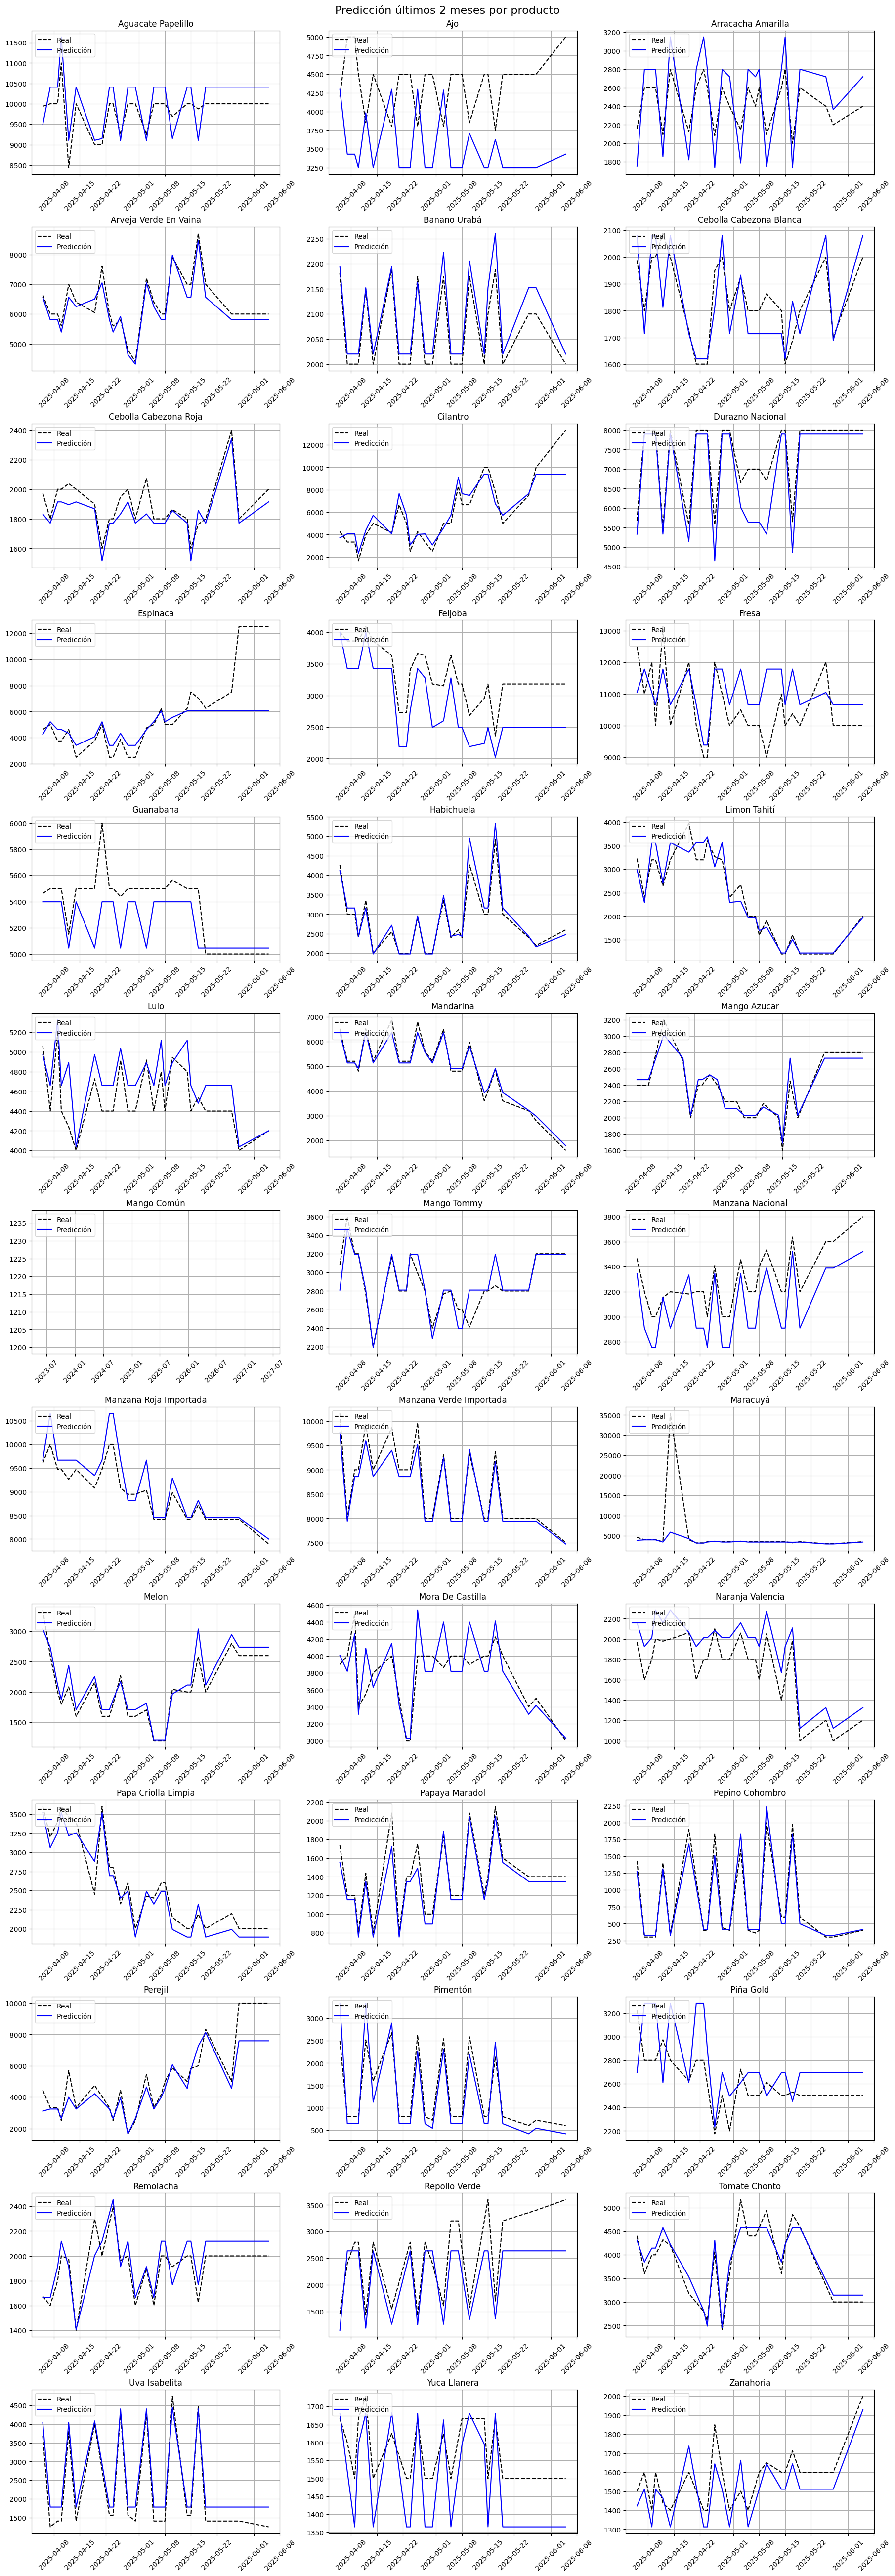

In [42]:
# ---------- GRAFICAR ----------

n = len(graficas)
cols = 3
rows = (n + cols - 1) // cols  # Calcular número de filas necesarias

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), constrained_layout=True)
axes = axes.flatten()  # Aplanar matriz de ejes

for i, graf in enumerate(graficas):
    ax = axes[i]
    
    ax.plot(graf['ds'], graf['real'], label='Real', color='black', linestyle='--')
    ax.plot(graf['ds'], graf['pred'], label='Predicción', color='blue')
    
    ax.set_title(graf['producto'])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    ax.legend(loc='upper left')

# Eliminar subplots vacíos si hay menos productos que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Predicción últimos 2 meses por producto', fontsize=16)
plt.show()


## Entrenamiento del Modelo con todos los datos 

In [43]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

productos = df_completo['Producto'].unique()

graficas_futuras = []

for producto in productos:
    try:
        # Filtrar y preparar datos
        df_producto = df_completo[df_completo['Producto'] == producto].copy()
        df_producto = df_producto.rename(columns={'Fecha': 'ds', 'Precio_Sogamoso': 'y'})

        columnas = ['ds', 'y', 'Precio_Duitama', 'Precio_Tunja', 'Precio_Bogotá', 'Promedio_Mercados']
        if not all(col in df_producto.columns for col in columnas):
            continue

        df_producto = df_producto[columnas].dropna()
        if len(df_producto) < 30:
            continue

        df_producto = df_producto.sort_values('ds').reset_index(drop=True)

        # Entrenar con el 100% de los datos
        model = Prophet(
            changepoint_prior_scale=0.5,
            n_changepoints=40,
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False
        )

        # Agregar regresores
        model.add_regressor('Precio_Duitama')
        model.add_regressor('Precio_Tunja')
        model.add_regressor('Precio_Bogotá')
        model.add_regressor('Promedio_Mercados')

        model.fit(df_producto)

        # Generar nuevas fechas para 1 mes
        last_date = df_producto['ds'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

        # Repetir últimos valores de regresores (asumiendo estabilidad reciente)
        ultimos_valores = df_producto[columnas[2:]].iloc[-1:]
        future_regresores = pd.concat([ultimos_valores] * len(future_dates), ignore_index=True)
        future_regresores['ds'] = future_dates

        # Ordenar columnas para el modelo
        future = future_regresores[['ds', 'Precio_Duitama', 'Precio_Tunja', 'Precio_Bogotá', 'Promedio_Mercados']]

        # Predecir
        forecast = model.predict(future)

        # Extraer último mes real
        ultimo_mes_real = df_producto[df_producto['ds'] > df_producto['ds'].max() - pd.Timedelta(days=30)]

        graficas_futuras.append({
            'producto': producto,
            'ds_real': ultimo_mes_real['ds'],
            'real': ultimo_mes_real['y'],
            'ds_pred': forecast['ds'],
            'pred': forecast['yhat'],
            'lower': forecast['yhat_lower'],
            'upper': forecast['yhat_upper']
        })

    except Exception as e:
        print(f"Error con producto {producto}: {e}")


11:47:44 - cmdstanpy - INFO - Chain [1] start processing
11:47:47 - cmdstanpy - INFO - Chain [1] done processing
11:47:47 - cmdstanpy - INFO - Chain [1] start processing
11:47:51 - cmdstanpy - INFO - Chain [1] done processing
11:47:51 - cmdstanpy - INFO - Chain [1] start processing
11:47:54 - cmdstanpy - INFO - Chain [1] done processing
11:47:54 - cmdstanpy - INFO - Chain [1] start processing
11:47:57 - cmdstanpy - INFO - Chain [1] done processing
11:47:57 - cmdstanpy - INFO - Chain [1] start processing
11:48:00 - cmdstanpy - INFO - Chain [1] done processing
11:48:00 - cmdstanpy - INFO - Chain [1] start processing
11:48:03 - cmdstanpy - INFO - Chain [1] done processing
11:48:03 - cmdstanpy - INFO - Chain [1] start processing
11:48:04 - cmdstanpy - INFO - Chain [1] done processing
11:48:04 - cmdstanpy - INFO - Chain [1] start processing
11:48:07 - cmdstanpy - INFO - Chain [1] done processing
11:48:07 - cmdstanpy - INFO - Chain [1] start processing
11:48:08 - cmdstanpy - INFO - Chain [1]

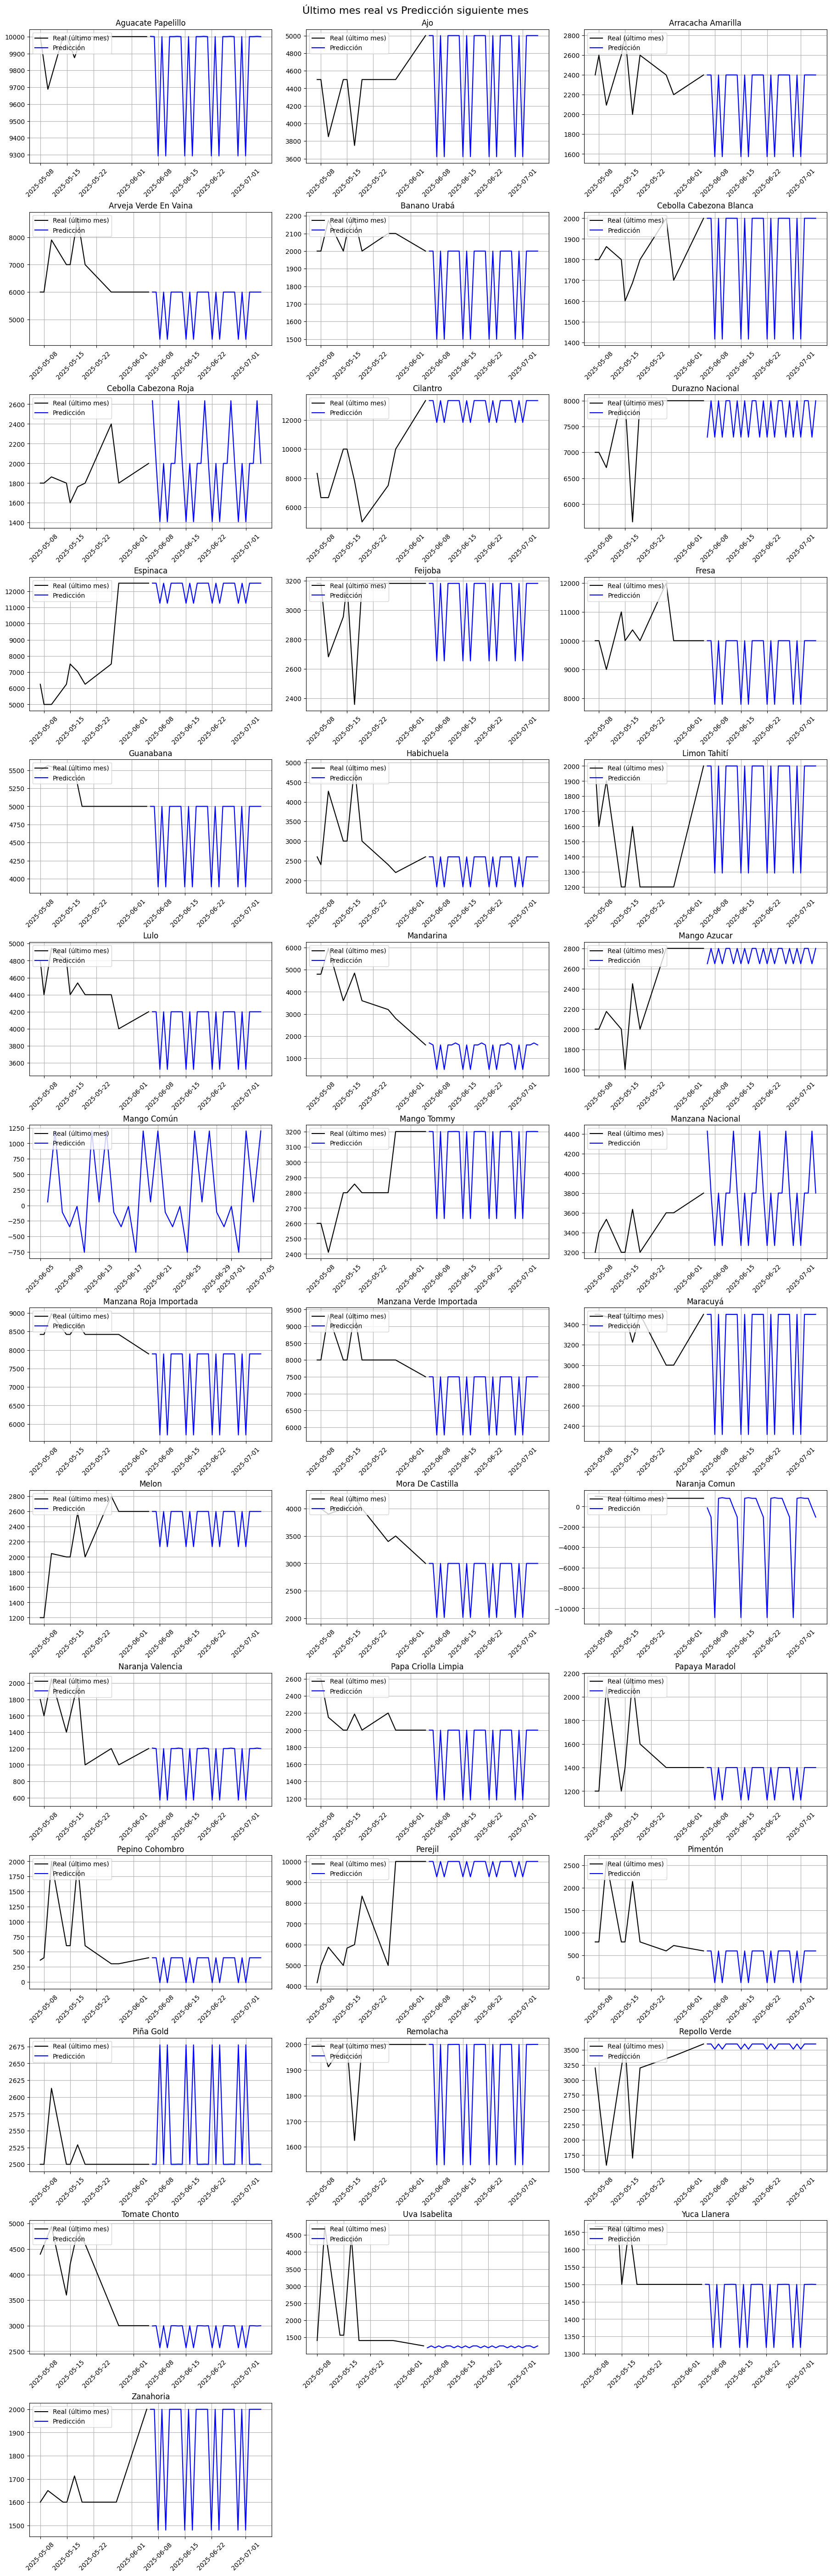

In [44]:
# ----------- GRAFICAR REAL VS PREDICCIÓN -----------
n = len(graficas_futuras)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), constrained_layout=True)
axes = axes.flatten()

for i, graf in enumerate(graficas_futuras):
    ax = axes[i]

    # Real del último mes
    ax.plot(graf['ds_real'], graf['real'], label='Real (último mes)', color='black')

    # Predicción del mes siguiente
    ax.plot(graf['ds_pred'], graf['pred'], label='Predicción', color='blue')
    ax.fill_between(graf['ds_pred'], graf['lower'], graf['upper'], color='lightblue', alpha=0.4)

    ax.set_title(graf['producto'])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    ax.legend(loc='upper left')

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Último mes real vs Predicción siguiente mes', fontsize=16)
plt.show()


## Generar variables de cambio por dia

In [52]:
df_predicciones = pd.DataFrame()

for g in graficas_futuras:
    temp = pd.DataFrame({
        'Producto': g['producto'],
        'Fecha': g['ds_pred'],
        'Prediccion': g['pred'],
        'Limite_inferior': g['lower'],
        'Limite_superior': g['upper']
    })
    df_predicciones = pd.concat([df_predicciones, temp], ignore_index=True)

# Visualizar
print(df_predicciones.head())


             Producto      Fecha    Prediccion  Limite_inferior  \
0  Aguacate Papelillo 2025-06-06  10001.571694      9996.190550   
1  Aguacate Papelillo 2025-06-07   9999.853628      9994.654547   
2  Aguacate Papelillo 2025-06-08   9293.354732      9288.502320   
3  Aguacate Papelillo 2025-06-09   9999.947703      9994.900786   
4  Aguacate Papelillo 2025-06-10   9293.355001      9288.377767   

   Limite_superior  
0     10006.673900  
1     10004.705548  
2      9297.988066  
3     10004.964471  
4      9298.185749  


In [53]:
# Ordenar por producto y fecha para asegurar el cálculo correcto
df_predicciones = df_predicciones.sort_values(['Producto', 'Fecha']).reset_index(drop=True)

# Calcular diferencia de la predicción entre fechas por producto
df_predicciones['cambio'] = df_predicciones.groupby('Producto')['Prediccion'].diff()

# Clasificar el cambio
df_predicciones['movimiento'] = df_predicciones['cambio'].apply(
    lambda x: 'subió' if x > 0 else ('bajó' if x < 0 else ('se mantuvo' if x == 0 else 'sin datos'))
)

# Mostrar las primeras filas del DataFrame con la nueva columna
print(df_predicciones[['Producto', 'Fecha', 'Prediccion', 'cambio', 'movimiento']].head(20))


              Producto      Fecha    Prediccion      cambio movimiento
0   Aguacate Papelillo 2025-06-06  10001.571694         NaN  sin datos
1   Aguacate Papelillo 2025-06-07   9999.853628   -1.718066       bajó
2   Aguacate Papelillo 2025-06-08   9293.354732 -706.498896       bajó
3   Aguacate Papelillo 2025-06-09   9999.947703  706.592972      subió
4   Aguacate Papelillo 2025-06-10   9293.355001 -706.592702       bajó
5   Aguacate Papelillo 2025-06-11  10000.235981  706.880980      subió
6   Aguacate Papelillo 2025-06-12  10000.021554   -0.214427       bajó
7   Aguacate Papelillo 2025-06-13  10001.571348    1.549793      subió
8   Aguacate Papelillo 2025-06-14   9999.853282   -1.718066       bajó
9   Aguacate Papelillo 2025-06-15   9293.354386 -706.498896       bajó
10  Aguacate Papelillo 2025-06-16   9999.947358  706.592972      subió
11  Aguacate Papelillo 2025-06-17   9293.354655 -706.592702       bajó
12  Aguacate Papelillo 2025-06-18  10000.235635  706.880980      subió
13  Ag

In [57]:
df_predicciones['Producto'].value_counts()

Producto
Aguacate Papelillo         30
Ajo                        30
Arracacha Amarilla         30
Arveja Verde En Vaina      30
Banano Urabá               30
Cebolla Cabezona Blanca    30
Cebolla Cabezona Roja      30
Cilantro                   30
Durazno Nacional           30
Espinaca                   30
Feijoba                    30
Fresa                      30
Guanabana                  30
Habichuela                 30
Limon Tahití               30
Lulo                       30
Mandarina                  30
Mango Azucar               30
Mango Común                30
Mango Tommy                30
Manzana Nacional           30
Manzana Roja Importada     30
Manzana Verde Importada    30
Maracuyá                   30
Melon                      30
Mora De Castilla           30
Naranja Comun              30
Naranja Valencia           30
Papa Criolla Limpia        30
Papaya Maradol             30
Pepino Cohombro            30
Perejil                    30
Pimentón                   30
P

In [58]:
df_predicciones.to_csv('../Data/outputs/df_Predicciones_completo_con_cambios.csv', index=False)

### Dataframe Original

In [59]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30073 entries, 0 to 30072
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              30073 non-null  datetime64[ns]
 1   Producto           30073 non-null  object        
 2   Precio_Sogamoso    30073 non-null  float64       
 3   Precio_Tunja       30073 non-null  float64       
 4   Precio_Duitama     30073 non-null  float64       
 5   Precio_Bogotá      30073 non-null  float64       
 6   Promedio_Mercados  30073 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.6+ MB


In [60]:
# Asegúrate de que esté ordenado por producto y fecha
df_completo = df_completo.sort_values(['Producto', 'Fecha']).reset_index(drop=True)

# Calcular el cambio del precio de Sogamoso por producto
df_completo['cambio'] = df_completo.groupby('Producto')['Precio_Sogamoso'].diff()

# Clasificar el movimiento: subió, bajó o se mantuvo
df_completo['movimiento'] = df_completo['cambio'].apply(
    lambda x: 'subió' if x > 0 else ('bajó' if x < 0 else ('se mantuvo' if x == 0 else 'sin datos'))
)


In [61]:
df_completo.head()
# Exportar datos
df_completo.to_csv('../Data/outputs/df_completo_con_cambios.csv', index=False)